In [1]:
# Week 7: User Personas via Unsupervised Learning
# Emanuel Gonzalez

# ============================================
# CELL 1: Download data from potions.gg
# ============================================
# Download data from potions.gg
!wget https://www.potions.gg/data/content_views.parquet
!wget https://www.potions.gg/data/adventurer_metadata.parquet
!wget https://www.potions.gg/data/subscriptions.parquet
!wget https://www.potions.gg/data/cancellations.parquet
!wget https://www.potions.gg/data/content_metadata.parquet

# Verify downloads
!ls -lh *.parquet







--2025-11-07 23:56:00--  https://www.potions.gg/data/content_views.parquet
Resolving www.potions.gg (www.potions.gg)... 185.199.109.153, 185.199.111.153, 185.199.108.153, ...
Connecting to www.potions.gg (www.potions.gg)|185.199.109.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1507631 (1.4M) [application/octet-stream]
Saving to: ‘content_views.parquet’

content_views.parqu 100%[===================>]   1.44M  --.-KB/s    in 0.05s   

2025-11-07 23:56:01 (26.3 MB/s) - ‘content_views.parquet’ saved [1507631/1507631]

--2025-11-07 23:56:01--  https://www.potions.gg/data/adventurer_metadata.parquet
Resolving www.potions.gg (www.potions.gg)... 185.199.110.153, 185.199.108.153, 185.199.109.153, ...
Connecting to www.potions.gg (www.potions.gg)|185.199.110.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 740561 (723K) [application/octet-stream]
Saving to: ‘adventurer_metadata.parquet’

adventurer_metadata 100%[===================>] 

In [2]:
# ============================================
# CELL 2: Import libraries
# ============================================
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

print("Libraries loaded successfully!")



Libraries loaded successfully!


In [3]:
# ============================================
# CELL 3: Load and clean data
# ============================================
print("="*60)
print("WEEK 7: USER PERSONA DISCOVERY")
print("="*60)

# Load data
df_views = pd.read_parquet("content_views.parquet")
df_metadata = pd.read_parquet("content_metadata.parquet")
df_adventurers = pd.read_parquet("adventurer_metadata.parquet")
df_subs = pd.read_parquet("subscriptions.parquet")
df_cancels = pd.read_parquet("cancellations.parquet")

print(f"\n[1] Data loaded:")
print(f"    Views: {len(df_views):,}")
print(f"    Adventurers: {len(df_adventurers):,}")
print(f"    Subscriptions: {len(df_subs):,}")
print(f"    Cancellations: {len(df_cancels):,}")

# Clean data
df_views = df_views.sort_values('seconds_viewed', ascending=False)\
    .drop_duplicates(subset=['adventurer_id', 'content_id'], keep='first')

df_merged = df_views.merge(
    df_metadata[['content_id', 'minutes']], 
    on='content_id', 
    how='left'
)
df_merged['watch_pct'] = (df_merged['seconds_viewed'] / (df_merged['minutes'] * 60)).clip(0, 1)

df_views_clean = df_merged[
    (df_merged['watch_pct'].fillna(0) >= 0.05) | 
    (df_merged['seconds_viewed'] >= 30)
].copy()

print(f"\n[2] Clean views: {len(df_views_clean):,}")

WEEK 7: USER PERSONA DISCOVERY

[1] Data loaded:
    Views: 186,753
    Adventurers: 35,771
    Subscriptions: 294,007
    Cancellations: 258,429

[2] Clean views: 90,707


In [4]:
# ============================================
# CELL 4: Build user profiles
# ============================================
print("\n[3] Building user profiles...")

# Viewing behavior
viewing_features = df_views_clean.groupby('adventurer_id').agg({
    'seconds_viewed': ['sum', 'mean', 'count'],
    'watch_pct': ['mean', 'median'],
    'content_id': 'nunique'
}).reset_index()

viewing_features.columns = ['adventurer_id', 
                            'total_watch_time', 
                            'avg_watch_time',
                            'num_views',
                            'avg_completion_rate',
                            'median_completion_rate',
                            'unique_content']

# Subscription behavior
sub_features = df_subs.groupby('adventurer_id').agg({
    'publisher_id': ['count', 'nunique']
}).reset_index()
sub_features.columns = ['adventurer_id', 'num_subscriptions', 'num_publishers']

# Churn behavior
churn_features = df_cancels.groupby('adventurer_id').size().reset_index(name='num_churns')

# Content preferences
df_views_enriched = df_views_clean.merge(
    df_metadata[['content_id', 'genre_id', 'language_code']], 
    on='content_id', 
    how='left'
)

genre_diversity = df_views_enriched.groupby('adventurer_id')['genre_id'].nunique().reset_index()
genre_diversity.columns = ['adventurer_id', 'genre_diversity']

lang_diversity = df_views_enriched.groupby('adventurer_id')['language_code'].nunique().reset_index()
lang_diversity.columns = ['adventurer_id', 'lang_diversity']

# Merge everything
user_profiles = df_adventurers[['adventurer_id', 'age']].copy()

for df in [viewing_features, sub_features, churn_features, 
           genre_diversity, lang_diversity]:
    user_profiles = user_profiles.merge(df, on='adventurer_id', how='left')

user_profiles = user_profiles.fillna(0)

print(f"    User profiles: {user_profiles.shape}")
print(f"    Features: {user_profiles.columns.tolist()}")


[3] Building user profiles...
    User profiles: (35771, 13)
    Features: ['adventurer_id', 'age', 'total_watch_time', 'avg_watch_time', 'num_views', 'avg_completion_rate', 'median_completion_rate', 'unique_content', 'num_subscriptions', 'num_publishers', 'num_churns', 'genre_diversity', 'lang_diversity']



[4] Clustering...
    k=3: Silhouette=0.327
    k=4: Silhouette=0.342
    k=5: Silhouette=0.336
    k=6: Silhouette=0.322
    k=7: Silhouette=0.337
    k=8: Silhouette=0.350


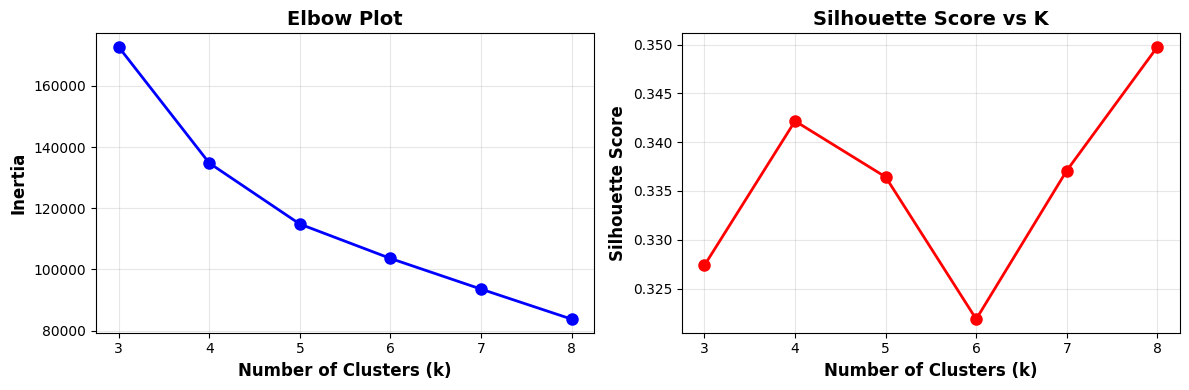


    🎯 Optimal k: 8 (Silhouette: 0.350)


In [5]:
# ============================================
# CELL 5: Clustering
# ============================================
print("\n[4] Clustering...")

clustering_features = [
    'total_watch_time',
    'avg_watch_time',
    'num_views',
    'unique_content',
    'avg_completion_rate',
    'num_subscriptions',
    'num_publishers',
    'num_churns',
    'genre_diversity',
    'lang_diversity'
]

X = user_profiles[clustering_features].copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Find optimal k
results = []
K_range = range(3, 9)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=20)
    labels = kmeans.fit_predict(X_scaled)
    
    silhouette = silhouette_score(X_scaled, labels)
    inertia = kmeans.inertia_
    
    results.append({
        'k': k,
        'silhouette': silhouette,
        'inertia': inertia
    })
    
    print(f"    k={k}: Silhouette={silhouette:.3f}")

results_df = pd.DataFrame(results)

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(results_df['k'], results_df['inertia'], 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('Number of Clusters (k)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Inertia', fontsize=12, fontweight='bold')
ax1.set_title('Elbow Plot', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

ax2.plot(results_df['k'], results_df['silhouette'], 'ro-', linewidth=2, markersize=8)
ax2.set_xlabel('Number of Clusters (k)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Silhouette Score', fontsize=12, fontweight='bold')
ax2.set_title('Silhouette Score vs K', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

optimal_k = int(results_df.loc[results_df['silhouette'].idxmax(), 'k'])
best_silhouette = results_df['silhouette'].max()
print(f"\n    🎯 Optimal k: {optimal_k} (Silhouette: {best_silhouette:.3f})")


[5] Cluster distribution:
      Cluster 0: 5,127 users (14.3%)
      Cluster 1: 6,399 users (17.9%)
      Cluster 2: 6,891 users (19.3%)
      Cluster 3: 5,595 users (15.6%)
      Cluster 4: 4,262 users (11.9%)
      Cluster 5: 3,027 users (8.5%)
      Cluster 6: 1,370 users (3.8%)
      Cluster 7: 3,100 users (8.7%)


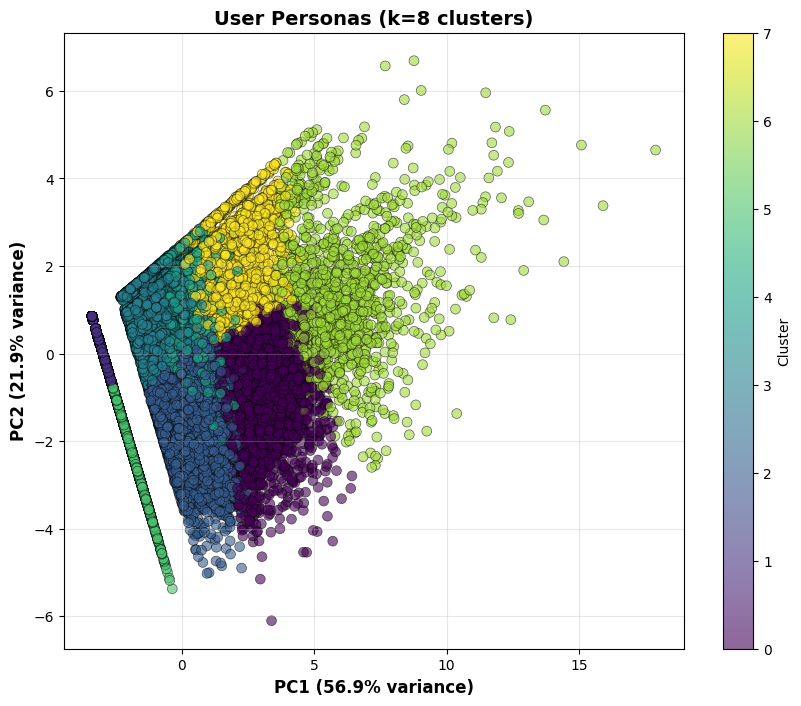

In [6]:
# ============================================
# CELL 6: Final clustering and visualization
# ============================================
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=20)
user_profiles['cluster'] = kmeans_final.fit_predict(X_scaled)

print(f"\n[5] Cluster distribution:")
for cluster_id in sorted(user_profiles['cluster'].unique()):
    count = (user_profiles['cluster'] == cluster_id).sum()
    pct = count / len(user_profiles) * 100
    print(f"      Cluster {cluster_id}: {count:,} users ({pct:.1f}%)")

# PCA visualization
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], 
                     c=user_profiles['cluster'], 
                     cmap='viridis', 
                     alpha=0.6, 
                     s=50,
                     edgecolors='black',
                     linewidth=0.5)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', 
          fontsize=12, fontweight='bold')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', 
          fontsize=12, fontweight='bold')
plt.title(f'User Personas (k={optimal_k} clusters)', 
         fontsize=14, fontweight='bold')
plt.colorbar(scatter, label='Cluster')
plt.grid(True, alpha=0.3)
plt.show()

In [7]:
# ============================================
# CELL 7: Persona insights
# ============================================
persona_insights = []

for cluster_id in sorted(user_profiles['cluster'].unique()):
    cluster_data = user_profiles[user_profiles['cluster'] == cluster_id]
    
    insight = {
        'cluster': cluster_id,
        'size': len(cluster_data),
        'avg_views': cluster_data['num_views'].mean(),
        'avg_completion': cluster_data['avg_completion_rate'].mean(),
        'avg_churns': cluster_data['num_churns'].mean(),
        'avg_subs': cluster_data['num_subscriptions'].mean(),
        'avg_age': cluster_data['age'].mean()
    }
    persona_insights.append(insight)

persona_df = pd.DataFrame(persona_insights)
print("\n" + "="*60)
print("PERSONA INSIGHTS")
print("="*60)
print(persona_df.round(2))



PERSONA INSIGHTS
   cluster  size  avg_views  avg_completion  avg_churns  avg_subs  avg_age
0        0  5127       5.02            0.55       14.12     15.41   367.48
1        1  6399       0.00            0.00        1.25      2.08   276.16
2        2  6891       2.01            0.33       11.98     12.97   442.93
3        3  5595       1.81            0.29        2.23      3.14   232.04
4        4  4262       1.65            0.80        6.02      6.98   437.31
5        5  3027       0.00            0.00       10.16     10.97   591.13
6        6  1370      11.94            0.57       12.15     13.61    60.59
7        7  3100       5.68            0.51        3.20      4.24   108.28



[6] Creating visualizations...


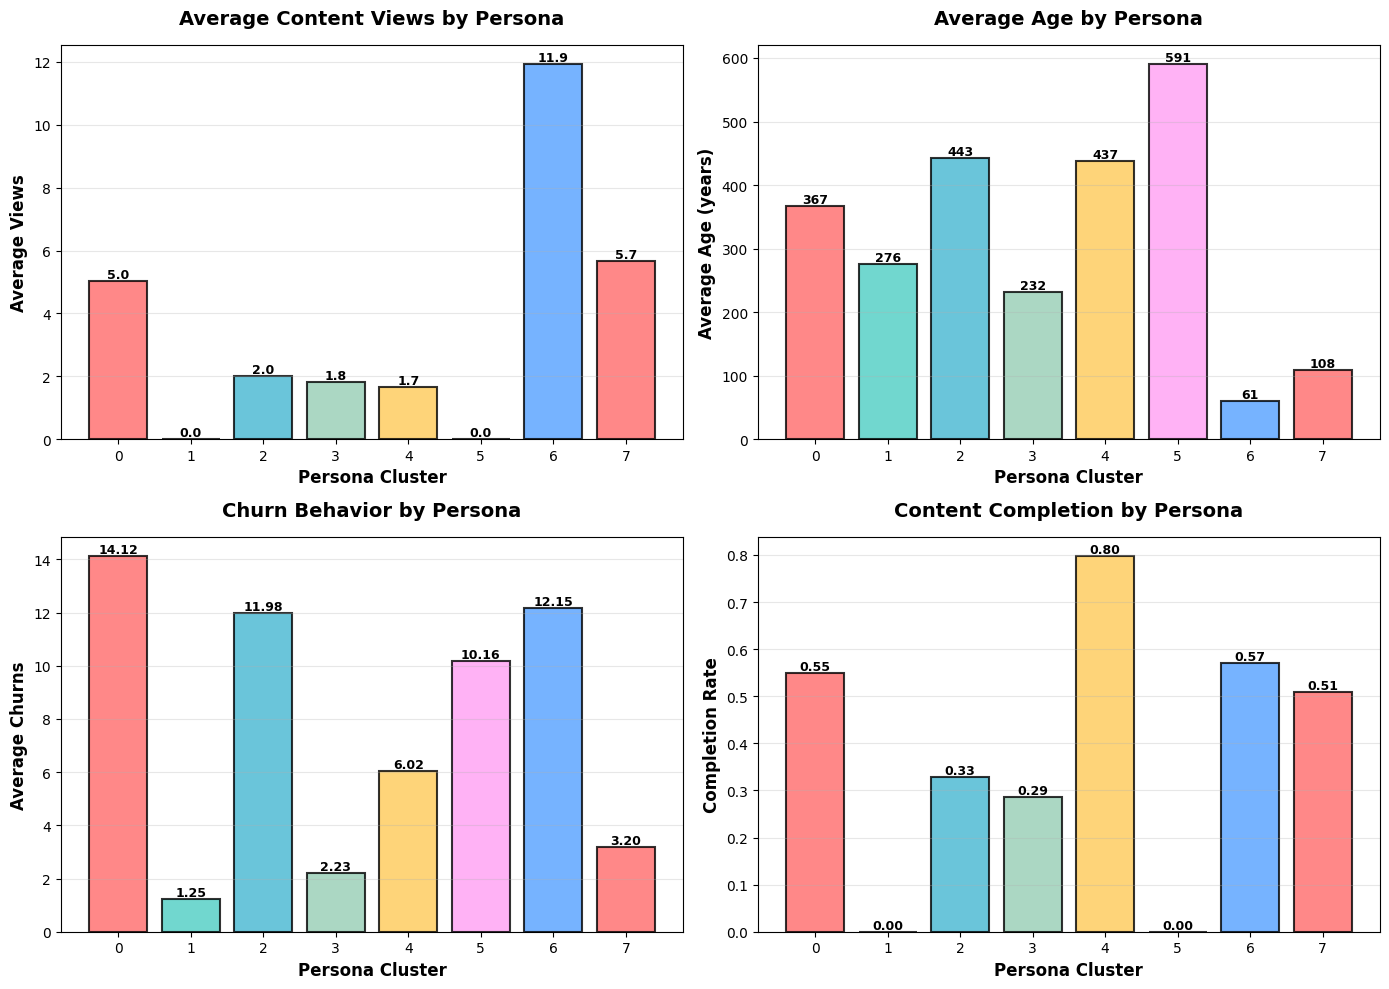


✅ COMPLETE!


In [8]:
# ============================================
# CELL 8: Visualizations
# ============================================
print("\n[6] Creating visualizations...")

colors = ['#ff6b6b', '#4ecdc4', '#45b7d1', '#96ceb4', '#feca57', '#ff9ff3', '#54a0ff']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
# Average Views
ax1 = axes[0, 0]
bars1 = ax1.bar(persona_df['cluster'], persona_df['avg_views'], 
                color=colors[:len(persona_df)], alpha=0.8, edgecolor='black', linewidth=1.5)
ax1.set_xlabel('Persona Cluster', fontweight='bold', fontsize=12)
ax1.set_ylabel('Average Views', fontweight='bold', fontsize=12)
ax1.set_title('Average Content Views by Persona', fontsize=14, fontweight='bold', pad=15)
ax1.grid(axis='y', alpha=0.3)

for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}',
            ha='center', va='bottom', fontweight='bold', fontsize=9)

# Average Age
ax2 = axes[0, 1]
bars2 = ax2.bar(persona_df['cluster'], persona_df['avg_age'], 
                color=colors[:len(persona_df)], alpha=0.8, edgecolor='black', linewidth=1.5)
ax2.set_xlabel('Persona Cluster', fontweight='bold', fontsize=12)
ax2.set_ylabel('Average Age (years)', fontweight='bold', fontsize=12)
ax2.set_title('Average Age by Persona', fontsize=14, fontweight='bold', pad=15)
ax2.grid(axis='y', alpha=0.3)

for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.0f}',
            ha='center', va='bottom', fontweight='bold', fontsize=9)

# Average Churns
ax3 = axes[1, 0]
bars3 = ax3.bar(persona_df['cluster'], persona_df['avg_churns'], 
                color=colors[:len(persona_df)], alpha=0.8, edgecolor='black', linewidth=1.5)
ax3.set_xlabel('Persona Cluster', fontweight='bold', fontsize=12)
ax3.set_ylabel('Average Churns', fontweight='bold', fontsize=12)
ax3.set_title('Churn Behavior by Persona', fontsize=14, fontweight='bold', pad=15)
ax3.grid(axis='y', alpha=0.3)

for bar in bars3:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2f}',
            ha='center', va='bottom', fontweight='bold', fontsize=9)

# Completion Rate
ax4 = axes[1, 1]
bars4 = ax4.bar(persona_df['cluster'], persona_df['avg_completion'], 
                color=colors[:len(persona_df)], alpha=0.8, edgecolor='black', linewidth=1.5)
ax4.set_xlabel('Persona Cluster', fontweight='bold', fontsize=12)
ax4.set_ylabel('Completion Rate', fontweight='bold', fontsize=12)
ax4.set_title('Content Completion by Persona', fontsize=14, fontweight='bold', pad=15)
ax4.grid(axis='y', alpha=0.3)

for bar in bars4:
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2f}',
            ha='center', va='bottom', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.show()

print("\n✅ COMPLETE!")